In [92]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import kmapper as km

from kmapper import jupyter
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

sns.set_style('whitegrid')

## Load extracted features

In [2]:
DATASET_NAME = "pathcontext"

In [3]:
# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

embedding_dim = vectors.values.shape[1]

# Merge vectors and labels
df = vectors.assign(method_name=labels)
df.dropna(inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,method_name
0,-0.725653,-0.683152,0.741892,-0.776258,0.261242,0.259904,0.456306,0.296833,0.300850,0.538582,...,-0.166784,-0.146298,0.244202,-0.761943,-0.869466,-0.236046,0.917939,-0.329328,0.544497,|wrap|indexin|verbose
1,0.516459,-0.422582,0.978825,0.039943,0.125243,0.161318,-0.917524,0.667879,-0.343896,0.690732,...,0.663024,-0.254368,-0.378047,0.625265,-0.331459,0.470658,0.641745,0.528675,0.190506,fast|norm
2,-0.725414,0.506977,-0.476344,-0.658100,-0.147991,0.541668,0.520115,0.764436,0.806276,-0.881450,...,-0.476050,0.921764,0.799426,0.635653,0.937958,0.602502,0.565932,-0.535572,-0.695010,asymptotic|decay
3,-0.875259,0.779345,0.054250,0.024057,-0.685877,0.631243,0.840025,0.433036,-0.298992,0.029438,...,0.815770,-0.235626,0.972460,0.472054,0.969310,0.870043,0.412882,0.514801,-0.904052,init
4,0.178146,0.575227,-0.396287,-0.458783,0.320927,-0.048418,0.426695,0.484011,0.740813,-0.822030,...,0.205781,0.259194,-0.857919,-0.471130,-0.732099,-0.480121,0.231000,-0.250182,0.630780,get|weights


## Data preparation

In [4]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict' }

In [5]:
# Assign categories based on method name
df['category'] = df.method_name.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
df

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,method_name,category
0,-0.725653,-0.683152,0.741892,-0.776258,0.261242,0.259904,0.456306,0.296833,0.300850,0.538582,...,-0.146298,0.244202,-0.761943,-0.869466,-0.236046,0.917939,-0.329328,0.544497,|wrap|indexin|verbose,0
1,0.516459,-0.422582,0.978825,0.039943,0.125243,0.161318,-0.917524,0.667879,-0.343896,0.690732,...,-0.254368,-0.378047,0.625265,-0.331459,0.470658,0.641745,0.528675,0.190506,fast|norm,0
2,-0.725414,0.506977,-0.476344,-0.658100,-0.147991,0.541668,0.520115,0.764436,0.806276,-0.881450,...,0.921764,0.799426,0.635653,0.937958,0.602502,0.565932,-0.535572,-0.695010,asymptotic|decay,0
3,-0.875259,0.779345,0.054250,0.024057,-0.685877,0.631243,0.840025,0.433036,-0.298992,0.029438,...,-0.235626,0.972460,0.472054,0.969310,0.870043,0.412882,0.514801,-0.904052,init,0
4,0.178146,0.575227,-0.396287,-0.458783,0.320927,-0.048418,0.426695,0.484011,0.740813,-0.822030,...,0.259194,-0.857919,-0.471130,-0.732099,-0.480121,0.231000,-0.250182,0.630780,get|weights,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43356,-0.204062,0.625377,0.945899,0.905877,-0.387782,0.841218,-0.866729,0.724075,0.340510,-0.611382,...,0.802036,0.745281,0.949823,0.978508,0.830064,-0.382665,0.559881,-0.871805,|write|assets,0
43357,0.519410,0.791364,-0.898711,-0.715481,-0.349882,0.905396,0.606571,-0.092363,-0.816942,-0.880497,...,-0.634648,0.716789,0.671302,-0.630433,-0.782766,0.293474,-0.257576,-0.870047,|build|regression|signature,0
43358,-0.474340,-0.523675,-0.557740,-0.035609,-0.377158,0.445920,-0.856099,-0.936300,-0.195115,-0.578930,...,-0.619492,-0.485829,-0.764330,0.629064,0.589313,0.395880,-0.164097,0.444280,|build|classification|signature,0
43359,-0.062574,-0.313517,0.054844,-0.485030,0.093782,-0.701090,-0.623037,-0.647554,-0.175082,0.650632,...,-0.322848,-0.681745,-0.757758,0.397109,0.413187,0.599990,0.362820,0.869774,|generate|saved|model|for|half|plus|two,1


In [6]:
df.groupby('category').size()

category
0    41984
1      333
2      390
3      241
4      413
dtype: int64

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2) 

In [8]:
train_features = train_df.iloc[:, 0:embedding_dim].values
test_features = test_df.iloc[:, 0:embedding_dim].values

In [9]:
train_features.shape, test_features.shape

((34688, 384), (8673, 384))

## Train an Autoencoder to (optionally) reduce the dimensionality of the features

In [10]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(embedding_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
## Train autoencoder

latent_dim = 10
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(train_features, train_features,
                epochs=20,
                shuffle=True,
                validation_data=(test_features, test_features),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)])

Epoch 1/20
1084/1084 [==============================] - 2s 1ms/step - loss: 0.3913 - val_loss: 0.2976
Epoch 2/20
1084/1084 [==============================] - 1s 719us/step - loss: 0.2965 - val_loss: 0.2915
Epoch 3/20
1084/1084 [==============================] - 1s 731us/step - loss: 0.2912 - val_loss: 0.2872
Epoch 4/20
1084/1084 [==============================] - 1s 738us/step - loss: 0.2870 - val_loss: 0.2832
Epoch 5/20
1084/1084 [==============================] - 1s 735us/step - loss: 0.2836 - val_loss: 0.2808
Epoch 6/20
1084/1084 [==============================] - 1s 751us/step - loss: 0.2812 - val_loss: 0.2796
Epoch 7/20
1084/1084 [==============================] - 1s 916us/step - loss: 0.2804 - val_loss: 0.2790
Epoch 8/20
1084/1084 [==============================] - 1s 845us/step - loss: 0.2800 - val_loss: 0.2785
Epoch 9/20
1084/1084 [==============================] - 1s 725us/step - loss: 0.2793 - val_loss: 0.2782
Epoch 10/20
1084/1084 [==============================] - 1s 765us/

## Choose a subset of samples
We'll only consider a subset of samples for visualization. This is done by taking an equal number of instances from each category.

In [12]:
df_subset = df.groupby('category').apply(lambda grp: grp.sample(n=100)).reset_index(level=[0, 1], drop=True)
df_subset.groupby('category').size()

category
0    100
1    100
2    100
3    100
4    100
dtype: int64

In [13]:
# Choose the "default" high dim features
features = df_subset.iloc[:, 0:embedding_dim].values

# Map the features into a low dimensional space using the encoder
# features = autoencoder.encoder(df_subset.iloc[:, 0:embedding_dim].values).numpy()
features.shape

(500, 384)

### Declare methods for computing metrics and visualizing clusters

In [107]:
def plot_clusters(estimator, dataframe, labels):
    # Get features from dataframe
    features = dataframe.iloc[:, 0:embedding_dim].values
    estimator_name = estimator.__class__.__name__
    k = len(np.unique(labels))
    # Print metrics
    print('Number of clusters: %d' % k)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataframe['category'], labels))
    print("Completeness: %0.3f" % metrics.completeness_score(dataframe['category'], labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataframe['category'], labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(dataframe['category'], labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(dataframe['category'], labels))
    print("Jaccard Coefficients: %s"
          % metrics.jaccard_score(dataframe['category'], labels, average=None))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(features, labels, metric='sqeuclidean'))

    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title(f'{estimator_name} Clusters (k={k})')
#     ax1.set_xlabel('TSNE X');ax1.set_ylabel('TSNE Y');ax1.set_zlabel('TSNE Z')
#     ax1.set_xticklabels([]);ax1.set_yticklabels([]);ax1.set_zticklabels([])
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    if estimator_name == 'OPTICS':
        ax1.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=f'Cluster ID {klass}')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Method names as labels')
#     ax2.set_xlabel('TSNE X');ax2.set_ylabel('TSNE Y');ax2.set_zlabel('TSNE Z')
#     ax2.set_xticklabels([]);ax2.set_yticklabels([]);ax2.set_zticklabels([])
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(classes)), colors):
        Xk = tsne_result[dataframe['category'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
    ax2.legend()
    
    ax2.legend(title='Method name', bbox_to_anchor=(0.5, -0.2), loc='lower center', fancybox=True, ncol=klass+1)
    fig.tight_layout()
    plt.savefig(f"./figures/code2vec_{DATASET_NAME}_{estimator.__class__.__name__}.svg")
    
#     tikzplotlib.clean_figure()
#     tikzplotlib.save(f"./figures/code2vec_{DATASET_NAME}_{estimator.__class__.__name__}.tex")
    
    
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

In [29]:
# Use tSNE & clustering
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.714730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 130.849228
[t-SNE] KL divergence after 3000 iterations: 1.896657


## Model fitting and hyperparameter search

In [30]:
estimators = OrderedDict()

### Centroid-based clustering using K-means

Best silhouette score 0.163 achieved with 10 clusters
Number of clusters: 10
Homogeneity: 0.190
Completeness: 0.141
V-measure: 0.162
Adjusted Rand Index: 0.142
Adjusted Mutual Information: 0.145
Jaccard Coefficients: [0.11363636 0.01948052 0.05982906 0.56818182 0.07142857 0.
 0.         0.         0.         0.        ]
Silhouette Coefficient: 0.163


<IPython.core.display.Javascript object>


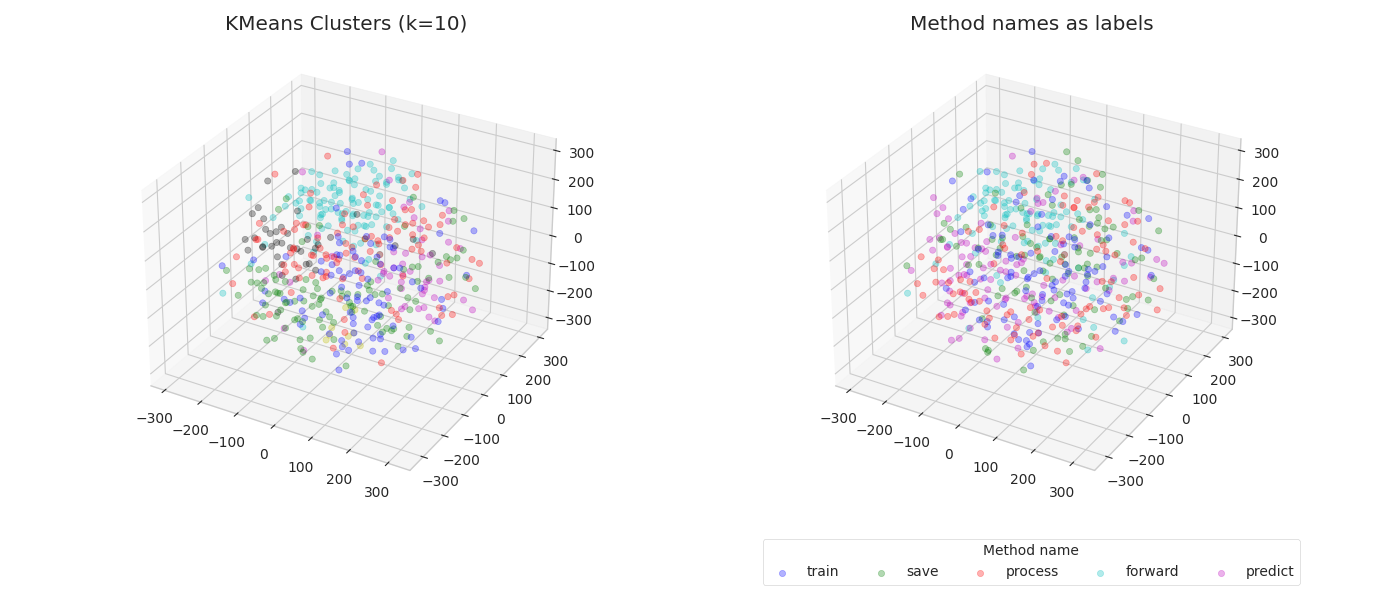

In [108]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
k = search_params['n_clusters'][ind]

print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {k} clusters")
kmeans_estimator = KMeans(n_clusters=k, random_state=0)
estimators[get_estimator_name(kmeans_estimator)] = { 'estimator': kmeans_estimator, 'score':  max_silhouette_score }

kmeans = kmeans_estimator.fit(features)
plot_clusters(kmeans, df_subset, kmeans.labels_)

### Density-Based Clustering using OPTICS

Best silhouette score 0.160 achieved with {'cluster_method': 'xi', 'metric': 'cosine', 'min_samples': 5, 'xi': 0.6000000000000001}
Number of clusters: 11
Homogeneity: 0.157
Completeness: 0.334
V-measure: 0.213
Adjusted Rand Index: 0.016
Adjusted Mutual Information: 0.180
Jaccard Coefficients: [0.   0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Silhouette Coefficient: -0.243


<IPython.core.display.Javascript object>


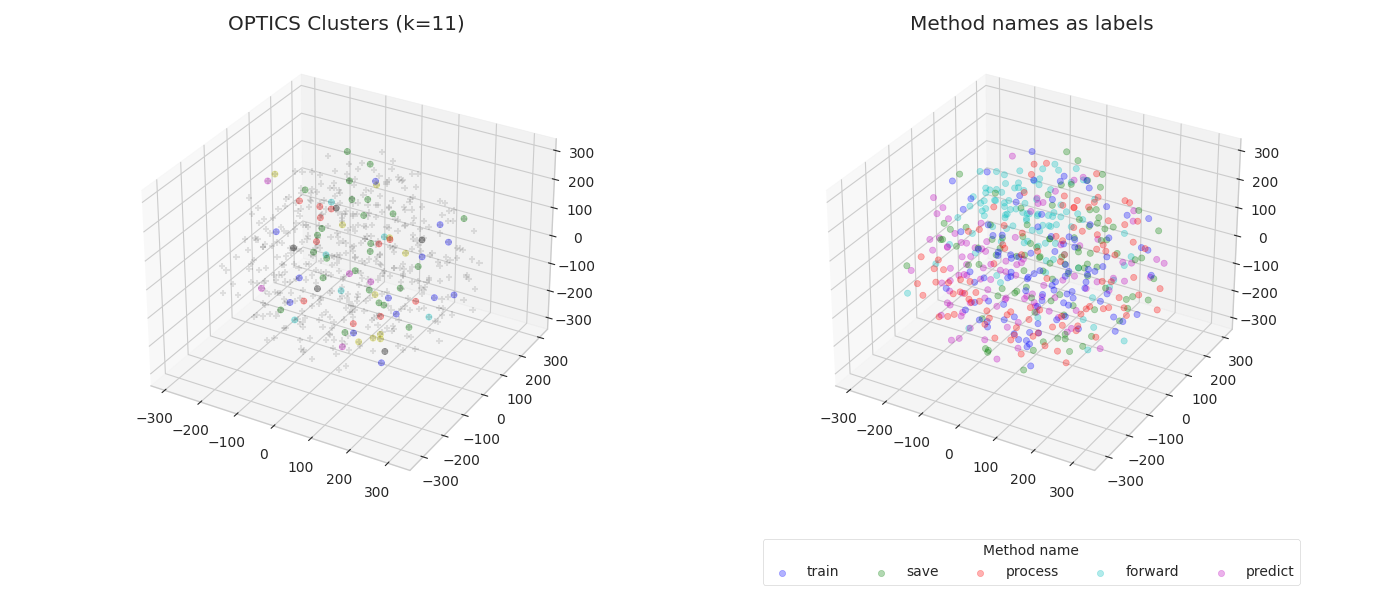

In [109]:
search_params = {'cluster_method': ['xi', 'dbscan'], 'xi': np.linspace(0,1,11), 'min_samples': [2,5,10,15,20,25,30], 'metric': ['minkowski', 'cosine', 'euclidean', 'sqeuclidean']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['min_samples']
metric = best_params['metric']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
optics_estimator = OPTICS(cluster_method='xi', min_samples=k, metric=metric)
estimators[get_estimator_name(optics_estimator)] = { 'estimator': optics_estimator, 'score':  max_silhouette_score }

optics_clusters = optics_estimator.fit(features)
plot_clusters(optics_clusters, df_subset, optics_clusters.labels_[optics_clusters.ordering_])

### Agglomerative Clustering (Hierarchical)

Best silhouette score 0.247 achieved with {'linkage': 'single', 'n_clusters': 2}
Number of clusters: 2
Homogeneity: 0.002
Completeness: 0.141
V-measure: 0.004
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Jaccard Coefficients: [0.19839679 0.00990099 0.         0.         0.        ]
Silhouette Coefficient: 0.247


<IPython.core.display.Javascript object>


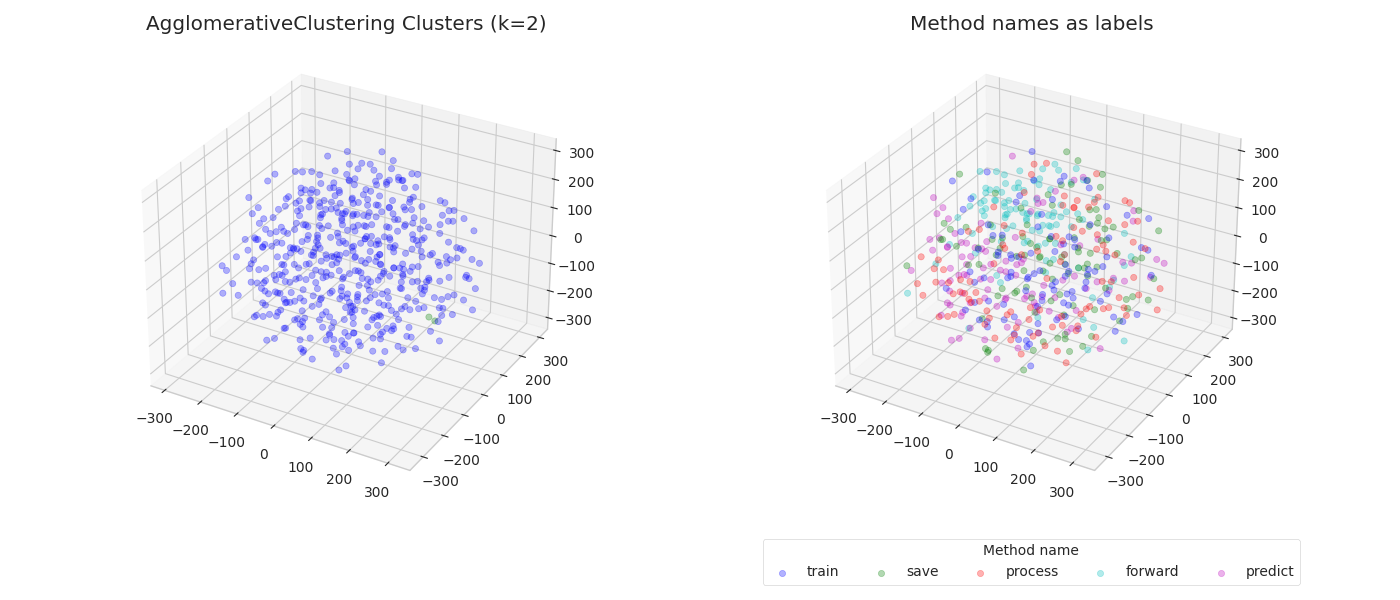

In [110]:
search_params = {'n_clusters': np.arange(2,11), 'linkage': ['ward', 'complete', 'average', 'single']}
# search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['n_clusters']
linkage = best_params['linkage']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
estimators[get_estimator_name(agglomerative_estimator)] = { 'estimator': agglomerative_estimator, 'score':  max_silhouette_score}

agglomerative_clusters = agglomerative_estimator.fit(features)
plot_clusters(agglomerative_clusters, df_subset, agglomerative_clusters.labels_)

## Select best estimator

In [20]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']

In [21]:
print(f"Best cluster method: {get_estimator_name(best_estimator)}\nParams:\n{best_estimator.__dict__}")

Best cluster method: AgglomerativeClustering
Params:
{'n_clusters': 2, 'distance_threshold': None, 'memory': None, 'connectivity': None, 'compute_full_tree': 'auto', 'linkage': 'single', 'affinity': 'euclidean', 'compute_distances': False, 'n_features_in_': 384, 'children_': array([[356, 374],
       [312, 326],
       [315, 380],
       [305, 362],
       [404, 455],
       [274, 284],
       [117, 127],
       [114, 170],
       [111, 151],
       [105, 180],
       [230, 266],
       [119, 120],
       [440, 413],
       [271, 273],
       [472, 425],
       [355, 318],
       [135, 141],
       [ 35,  62],
       [406, 448],
       [252, 262],
       [337, 339],
       [323, 316],
       [519, 240],
       [521, 302],
       [247, 422],
       [344, 357],
       [383, 314],
       [523, 520],
       [201, 227],
       [518, 453],
       [125, 138],
       [503, 360],
       [342, 340],
       [500, 501],
       [385, 533],
       [379, 375],
       [502, 535],
       [378, 334],
  

## Visualize Clusters with Kepler Mapper

In [22]:
# Visualize with kepler map
mapper = km.KeplerMapper(verbose=1)

# Fit and transform data, use TSNE 
projected_data = mapper.fit_transform(features, projection=TSNE(n_components=2))

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=best_estimator,
    cover=km.Cover(5, 0.3),
)

# Create the visualizations
print("Output graph examples to html")
mapper.visualize(
    graph,
    title=f"{DATASET_NAME} Mapper",
    path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_visualization.html",
    custom_tooltips=df_subset['label'].values
)

jupyter.display(path_html=f"./data/{DATASET_NAME}/{DATASET_NAME}_visualization.html")

KeplerMapper(verbose=1)


NameError: name 'low_dim_features' is not defined